## CNN logistic


Only photos with max 960 in axis X and Y

MSE 



In [1]:
# !pip install keras
# !pip install tensorflow-addons

In [2]:
import sys
sys.path.append('../src')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

from tensorflow.keras import Sequential, Input, layers
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow_addons.metrics import FBetaScore

from tensorflow.keras.metrics import Recall, Precision
# from tensorflow_addons.metrics import F1Score

from utils.data import get_best_slice, select_tomo_ids, get_csv_from_bq
from utils.render_motor_position import get_motor_coordinates, get_slice_file_path


/Users/wm/.pyenv/versions/3.10.6/envs/byu/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/Users/wm/.pyenv/versions/3.10.6/envs/byu/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter 

In [35]:
path_train_csv= '../data/csv_raw/train_labels.csv'
# /Users/wm/code/mc-will/bacterial_motor/BYU_Locating-Bacterial_Flagellar_Motors_2025/data/csv_raw/train_labels.csv
path_image= '../data/pictures_raw/train'

df = pd.read_csv(path_train_csv).copy()


[500, 800, 600, 300, 400, 494]

In [4]:
# pd.serie with list of tomo (tomo_2dd6bd)
tomogram_id= select_tomo_ids(df,)


In [5]:
# adding the IF on Thomas's fonction

def get_best_slice(df, tomogram_id):
    '''
    Find the coordinates of the motor (only work with 1 motor tomogram), the use the z to get the picture_path where
    the motor is located, i.e. the 'best slice'

            Parameters:
                df (pd.Dataframe): the dataset to find coordinates
                tomogram_id (string): the tomogram id

            Returns:
                best_slice_path (string): the path of the picture of the 'best slice' (where the motor is located)

    '''
    x, y, z = get_motor_coordinates(df, tomogram_id)
    if z <0:
        best_slice = 150
        best_slice_path = get_slice_file_path(tomogram_id, int(best_slice))
    else:
        best_slice_path = get_slice_file_path(tomogram_id, int(z))
    return best_slice_path

In [24]:
# list of paths : ['./data/pictures_raw/train/tomo_2dd6bd/slice_0150.jpg',    './data/pictures_raw/train/tomo_3264bc/slice_0150.jpg',...)
best_slice =[get_best_slice(df,tomo) for tomo in tomogram_id]
best_slice;


In [7]:
# give an arrary of (416,) into this X[0].shape= (928, 928, 1)

def load_slices(best_slice):
    slices = []
    for i in best_slice:
        relative_path = i.lstrip('./')
        img_path = Path('..') / relative_path


        img = load_img(img_path, color_mode='grayscale')
        img_array = img_to_array(img) / 255.0
        slices.append(img_array)

    return np.array(slices)


In [8]:
# selection of y= 1 or 0 Motors

X =load_slices(best_slice);

df_filtered = df[df['tomo_id'].isin(tomogram_id)]
y = df_filtered['Number_of_motors']

/var/folders/nr/0rc2wzzd26zd1tptqppt9kjr0000gn/T/ipykernel_26944/1099614466.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(slices)


In [9]:

target_size = (928, 928)
slices_resized = []

for i, img in enumerate(X):

    pil_img = Image.fromarray((img * 255).astype('uint8').squeeze())  # out one canal if it is 1
    pil_img = pil_img.resize(target_size)
    img_array = img_to_array(pil_img) / 255.0
    if img_array.ndim == 2:  # si vuelve a perder canal
        img_array = np.expand_dims(img_array, axis=-1)
    slices_resized.append(img_array)

X = np.stack(slices_resized)
X.shape


(416, 928, 928, 1)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test_kaggel, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [11]:
# CNN build
def init_model_cnnlog(X):
    model = Sequential()
    model.add(Input(shape= X.shape[1:]))

    model.add(layers.Conv2D(32, (3, 3),
                            padding='same',
                            activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    #
    model.add(layers.Conv2D(64, (3, 3),
                            padding='same',
                            activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(128, (3, 3),
                            padding='same',
                            activation="relu"))
    model.add(layers.BatchNormalization())

    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))


    model.add(layers.Dense(1, activation='sigmoid'))


    ########

    model.compile(loss= 'binary_crossentropy',
                  optimizer = 'adam',
                  metrics=['accuracy',
                           FBetaScore(num_classes=1,
                                      average='micro',
                                      beta=2.0),
                           Recall(),
                        #    'precision',
                           ],)

    return model


In [12]:
def model_train (model, X_train_processed, y_train, batch_size=16 ,epochs=5):
    verbose=1
    validation_split=0.1
    es = EarlyStopping(patience=3,
                       restore_best_weights=True)

    history = model.fit(X_train_processed,
                        y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        # validation_split=validation_split,
                        validation_data=(X_val, y_val),
                        callbacks=[es],
                        verbose=verbose)
    return history


In [15]:
model = init_model_cnnlog(X_train)

In [16]:

history = model_train(model, X_train,y_train)
history

Epoch 1/5


2025-06-05 12:29:30.676781: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


21/21 [==============================] - 773s 37s/step - loss: 21.8772 - accuracy: 0.6250 - fbeta_score: 0.8877 - recall_1: 0.7540 - val_loss: 2.2515 - val_accuracy: 0.2895 - val_fbeta_score: 0.9247 - val_recall_1: 0.0000e+00
Epoch 2/5
21/21 [==============================] - 616s 29s/step - loss: 0.5763 - accuracy: 0.7619 - fbeta_score: 0.9375 - recall_1: 0.9762 - val_loss: 0.6914 - val_accuracy: 0.3684 - val_fbeta_score: 0.9247 - val_recall_1: 0.2593
Epoch 3/5
21/21 [==============================] - 813s 38s/step - loss: 0.5010 - accuracy: 0.7619 - fbeta_score: 0.9375 - recall_1: 0.9405 - val_loss: 0.6301 - val_accuracy: 0.7105 - val_fbeta_score: 0.9247 - val_recall_1: 1.0000
Epoch 4/5
21/21 [==============================] - 1743s 85s/step - loss: 0.4874 - accuracy: 0.7738 - fbeta_score: 0.9375 - recall_1: 0.9722 - val_loss: 0.6299 - val_accuracy: 0.7105 - val_fbeta_score: 0.9247 - val_recall_1: 1.0000
Epoch 5/5
21/21 [==============================] - 623s 30s/step - loss: 0.4372 

In [17]:
history.history


{'loss': [21.87723159790039,
  0.5763416290283203,
  0.5009724497795105,
  0.48738202452659607,
  0.43723270297050476],
 'accuracy': [0.625,
  0.761904776096344,
  0.761904776096344,
  0.773809552192688,
  0.7976190447807312],
 'fbeta_score': [0.8877086639404297, 0.9375, 0.9375, 0.9375, 0.9375],
 'recall_1': [0.7539682388305664,
  0.976190447807312,
  0.9404761791229248,
  0.9722222089767456,
  0.976190447807312],
 'val_loss': [2.2514808177948,
  0.6914106607437134,
  0.6300923228263855,
  0.6299126744270325,
  0.7203736901283264],
 'val_accuracy': [0.28947368264198303,
  0.3684210479259491,
  0.7105262875556946,
  0.7105262875556946,
  0.28947368264198303],
 'val_fbeta_score': [0.9246575236320496,
  0.9246575236320496,
  0.9246575236320496,
  0.9246575236320496,
  0.9246575236320496],
 'val_recall_1': [0.0, 0.25925925374031067, 1.0, 1.0, 0.0]}

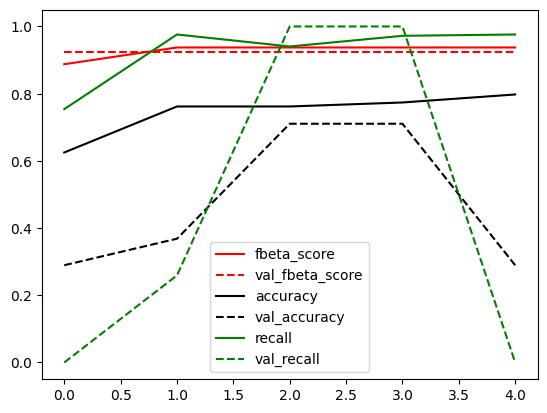

In [23]:
# plt.plot(history.history['mse'],c='b');
# plt.plot(history.history['val_mse'],c='black');

# plt.plot(history.history['loss'], c='b', label ='loss');
# plt.plot(history.history['val_loss'],c='b', linestyle='--', label = 'val_loss');


plt.plot(history.history['fbeta_score'], c='r', label="fbeta_score")
plt.plot(history.history['val_fbeta_score'], c='r', linestyle='--', label="val_fbeta_score")

plt.plot(history.history['accuracy'],c='black', label="accuracy")
plt.plot(history.history['val_accuracy'],c='black', linestyle='--', label="val_accuracy")


plt.plot(history.history['recall_1'], c= 'g', label="recall");
plt.plot(history.history['val_recall_1'], c= 'g', linestyle='--', label="val_recall");

# plt.plot(history.history['precision'], c='g');
# plt.plot(history.history['val_precision'], c='b');

plt.legend()

In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 928, 928, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 464, 464, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 464, 464, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 232, 232, 64)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 232, 232, 128)     73856     
                                                                 
 batch_normalization_1 (Batc  (None, 232, 232, 128)   

In [ ]:


path_test_csv = '../data/csv_raw/sample_submission.csv'
path_image_test = '../data/pictures_raw/test'


df_test = pd.read_csv(path_test_csv).copy()

# Obtener los tomogramas únicos
tomogram_ids = df_test['tomo_id'].unique()

# Parámetros
slice_number = 1
target_size = (928, 928)
X_test_kaggel = []

for tomo_id in tomogram_ids:
    folder_path = os.path.join(path_image_test, tomo_id)
    slice_name = f"slice_{slice_number:04d}.jpg"
    slice_path = os.path.join(folder_path, slice_name)

    if not os.path.exists(slice_path):
        print(f"⚠️ Slice not found: {slice_path}")
        continue

    # Cargar y procesar imagen
    img = load_img(slice_path, color_mode='grayscale')
    pil_img = img.resize(target_size)
    img_array = img_to_array(pil_img) / 255.0
    X_test_kaggel.append(img_array)

# Convertir a np.array
X_test_kaggel = np.array(X_test_kaggel)


In [ ]:
y_pred = model.predict(X_test_kaggel)

y_pred


In [8]:
# """
# Function look the foto 72 in each 'tomo'
# * Img size is too heavy at 960*960 pixel, so se test on 256*256

# """
# def load_from_each_tomo(parent_folder,
#                         img_size=(960, 960),
#                         # img_size=(256,256),
#                         # img_size=(128, 128),
#                         ):

#     slices = []
#     # select the column of 'tomo_id' with only 1/0 Motors
#     tomo_ids = df['tomo_id']
#     # print (tomo_ids)

#     # Loop to look each foto per Tomo_id
#     for id in tomo_ids:
#         # make the path btw parent_path and tomo_id
#         tomo_path = os.path.join(parent_folder, id)
#         # print(tomo_path)

#         # Check if it is a real directory
#         if os.path.isdir(tomo_path):
#             # make a liste of all the photo per tomo
#             all_slices = sorted([f for f in os.listdir(tomo_path)])
#             # print(' all slices:',len(all_slices), type(all_slices), all_slices)

#             number = 72 ### mean where the best photo is

#             slice_path =os.path.join(tomo_path, all_slices[number])
#             # load the img from slice_path with same size , in 1 chanel = W/B
#             img = load_img(slice_path,
#                            target_size=img_size,
#                            color_mode='grayscale',
#                            )
#             # Normalization btw 0/1 divide by 255
#             img_array = img_to_array(img) / 255

#             # append to the slice list
#             slices.append(img_array)

#     # return un array to be used
#     return np.array(slices)


In [29]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall
import tensorflow as tf
from tensorflow_addons.metrics import FBetaScore

def init_model_densenet(X):
    original_input_shape = X.shape[1:]

    # Forzar input a 3 canales si es gris (1 canal)
    if original_input_shape[-1] == 1:
        base_input_shape = original_input_shape[:-1] + (3,)
    else:
        base_input_shape = original_input_shape

    # Cargar modelo base DenseNet121 sin la capa de clasificación final
    base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=base_input_shape)
    base_model.trainable = False

    # Input layer
    inputs = Input(shape=original_input_shape)

    # Convertir a RGB si es necesario
    if original_input_shape[-1] == 1:
        x = Lambda(lambda x: tf.image.grayscale_to_rgb(x))(inputs)
    else:
        x = inputs

    # Aplicar modelo base
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)

    # Compilar
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=1e-4),
        metrics=[
            'accuracy',
            FBetaScore(num_classes=1, average='micro', beta=2.0),
            Recall()
        ]
    )

    return model


model_densenet = init_model_densenet(X_train)


history_densenet = model_train(model_densenet, X_train,y_train)
history_densenet

Epoch 1/5
21/21 [==============================] - 234s 11s/step - loss: 0.7322 - accuracy: 0.5893 - fbeta_score: 0.9375 - recall_2: 0.6905 - val_loss: 0.6120 - val_accuracy: 0.7105 - val_fbeta_score: 0.9247 - val_recall_2: 1.0000
Epoch 2/5
21/21 [==============================] - 330s 16s/step - loss: 0.5910 - accuracy: 0.7411 - fbeta_score: 0.9375 - recall_2: 0.9484 - val_loss: 0.5999 - val_accuracy: 0.7105 - val_fbeta_score: 0.9247 - val_recall_2: 1.0000
Epoch 3/5
21/21 [==============================] - 307s 15s/step - loss: 0.6347 - accuracy: 0.7202 - fbeta_score: 0.9375 - recall_2: 0.9365 - val_loss: 0.5751 - val_accuracy: 0.7105 - val_fbeta_score: 0.9247 - val_recall_2: 1.0000
Epoch 4/5
21/21 [==============================] - 327s 16s/step - loss: 0.6184 - accuracy: 0.7024 - fbeta_score: 0.9375 - recall_2: 0.9008 - val_loss: 0.5633 - val_accuracy: 0.7105 - val_fbeta_score: 0.9247 - val_recall_2: 1.0000
Epoch 5/5
21/21 [==============================] - 348s 17s/step - loss: 0.5

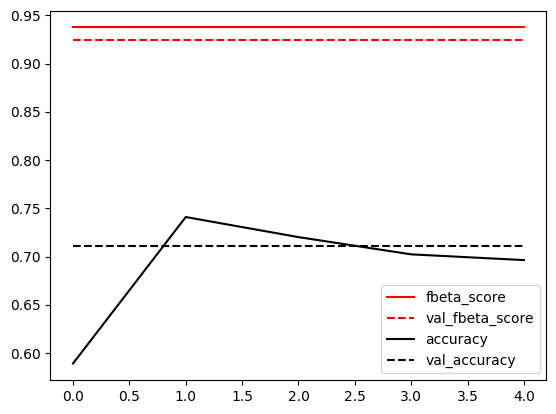

In [32]:
history_densenet.history


plt.plot(history_densenet.history['fbeta_score'], c='r', label="fbeta_score")
plt.plot(history_densenet.history['val_fbeta_score'], c='r', linestyle='--', label="val_fbeta_score")

plt.plot(history_densenet.history['accuracy'],c='black', label="accuracy")
plt.plot(history_densenet.history['val_accuracy'],c='black', linestyle='--', label="val_accuracy")


# plt.plot(history_densenet.history['recall_1'], c= 'g', label="recall");
# plt.plot(history_densenet.history['val_recall_1'], c= 'g', linestyle='--', label="val_recall");

# plt.plot(history.history['precision'], c='g');
# plt.plot(history.history['val_precision'], c='b');

plt.legend()

In [33]:
model_densenet.evaluate(X_test_kaggel,y_test)

2/2 [==============================] - 19s 4s/step - loss: 0.6487 - accuracy: 0.6190 - fbeta_score: 0.8904 - recall_2: 1.0000


[0.6486611366271973, 0.6190476417541504, 0.8904110193252563, 1.0]

In [34]:
model.evaluate(X_test_kaggel,y_test)

2/2 [==============================] - 5s 650ms/step - loss: 0.7017 - accuracy: 0.3810 - fbeta_score: 0.8904 - recall_1: 0.0000e+00


[0.7016727924346924, 0.380952388048172, 0.8904110193252563, 0.0]